# Modeling & Fitting

Jalankan kode di bawah ini untuk update modul prediksicovidjatim.
1. Klik bagian di bawah ini
2. Tekan "Y" di keyboard
3. Tekan Shift + Enter
4. Tunggu hingga muncul tulisan di bawahnya. Kalau sukses, di paling bawah, atau di atas kotak merah akan ada tulisan "Successfully installed prediksicovidjatim". Kotak merah hanya warning, bukan error.
5. Tekan lagi bagian di bawah ini (Di luar area kode)
6. Tekan "M" di keyboard
7. Tekan Shift + Enter
8. Restart & Run All

!pip install --upgrade --force-reinstall -e git://github.com/R-N/prediksicovidjatim-core.git#egg=prediksicovidjatim-core

In [19]:
import os
import sys
#sys.path.insert(0, "../../")

import mpld3
mpld3.enable_notebook()

import warnings
warnings.filterwarnings('ignore')

from prediksicovidjatim import util, config, database
from prediksicovidjatim.data.model import ModelDataRepo
from prediksicovidjatim.data.model.entities import *

database.init()
ModelDataRepo.init_weights()
config.init_plot()

### Get Data

In [20]:
selected_kabko = "KAB. SAMPANG"
kabko = ModelDataRepo.get_kabko_full(selected_kabko)

### Make Model

In [21]:
from prediksicovidjatim.modeling import SeicrdRlcModel

mod = SeicrdRlcModel(kabko)

### Fit!

Fitting dilakukan dalam 2 tahap:
1. Fitting awal. Fit hanya dilakukan sekali. Lakukan hingga kurva cukup baik.
2. Fitting + Test. Fit dilakukan 4 kali dengan 3 fit pertama adalah fit dengan dataset yang dibagi menjadi train set dan test set. 

Variable first_time di bawah menunjukkan fitting mana yang akan dilakukan. 
1. Jika melakukan fitting awal (1), first_time = True
2. Jika melakukan fitting + test (2), first_time = False

Perhatikan besar kecilnya.

In [22]:
first_time = True

In [23]:
first_time = first_time or not kabko.scored
if first_time:
    test_splits = []
else:
    test_splits = [3]

In [24]:
result = mod.fit(method="leastsq", test_splits=test_splits, first_time=first_time)
result.fit_result.message

'Fit succeeded. Could not estimate error-bars.'

### Fit Results

Params Should Have "standard error" and "relative error" Columns. If they dont:
1. A parameter might not be significant
2. A parameter has hit its min/max limit and can't vary

In [25]:
result.fit_result.params

name,value,standard error,relative error,initial value,min,max,vary
days,79.0000000,0.00000000,(0.00%),79,-inf,inf,False
population,989001.000,0.00000000,(0.00%),989001,-inf,inf,False
infectious_rate,0.33333333,0.03333333,(10.00%),0.33333333333333326,0.07142857,0.33333333,True
critical_chance,0.50000000,0.05000000,(10.00%),0.49999999998968137,0.01000000,0.50000000,True
critical_rate,0.14284977,0.01428498,(10.00%),0.14284977006414104,0.08333333,0.14285714,True
recovery_rate_normal,0.11111111,0.00000000,(0.00%),0.1111111111111111,-inf,inf,False
recovery_rate_critical,0.15384615,0.00000000,(0.00%),0.15384615384615385,-inf,inf,False
death_chance_normal,0.00500003,5.0000e-04,(10.00%),0.005000030959645634,0.00500000,3.33333333,True
death_rate_normal,0.11748043,0.01174804,(10.00%),0.1174804317,0.10000000,0.20000000,True
death_chance_over,1.00000000,0.00000000,(0.00%),1.0,-inf,inf,False


### Predict

In [26]:
values = dict(result.fit_result.values)
values["days"] += 30
values["days"]

109

In [27]:
model_result = mod.model(**values)

### Plot!

In [28]:
from prediksicovidjatim.modeling import ModelPlotter

plotter = ModelPlotter(model_result)

In [29]:
length = kabko.data_count + result.outbreak_shift
length

79

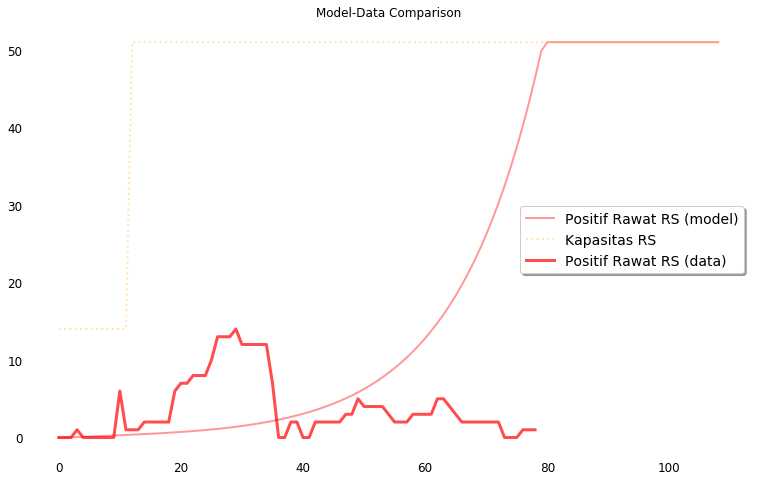

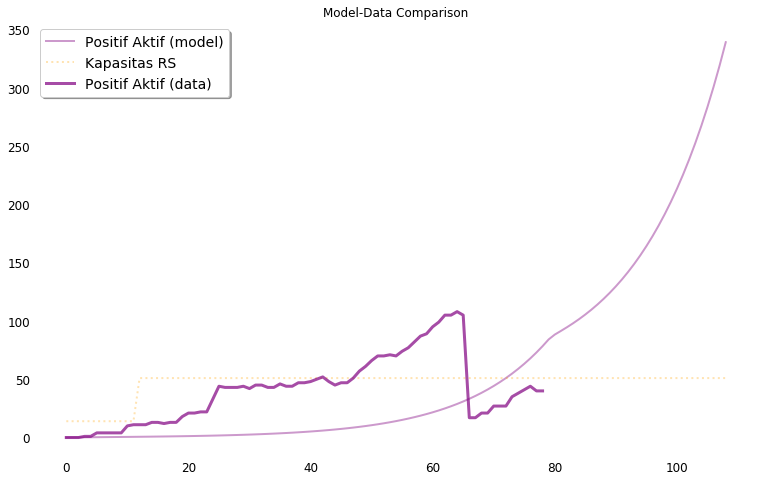

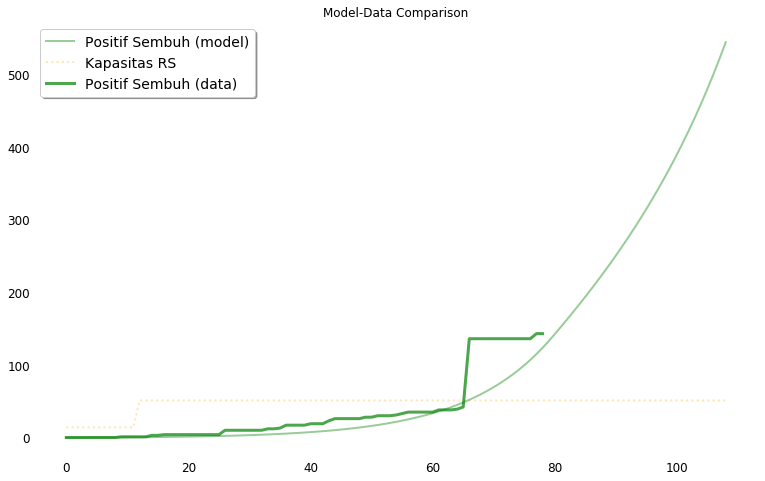

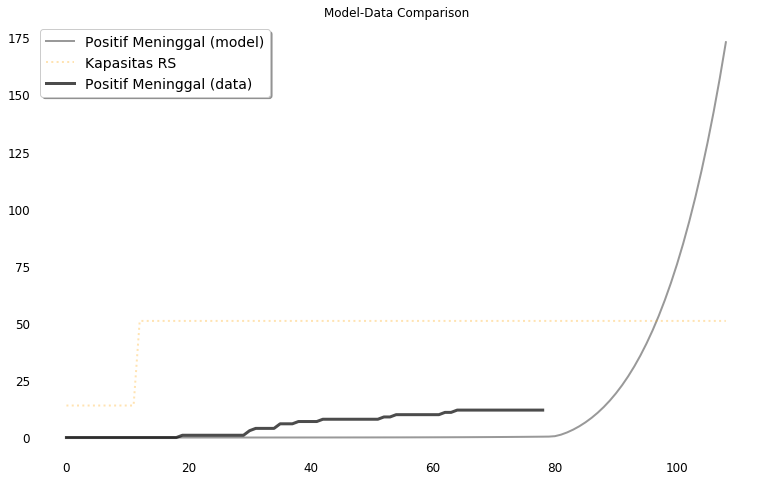

In [30]:
import matplotlib.pyplot as plt
for d in mod.datasets:
    datasets = kabko.get_datasets([d], result.outbreak_shift)
    plotter.plot(
        plotter.plot_main_data, 
        datasets,
        length
    )
    plt.show()

plotter.plot(plotter.plot_main_lite);

plotter.plot(plotter.plot_daily_lite);

plotter.plot(plotter.plot_r0);

plotter.plot(plotter.plot_mortality_rate);

plotter.plot(plotter.plot_over);

plotter.plot(plotter.plot_dead);

plotter.plot(plotter.plot_healthcare);

### Model Scores

In [31]:
print("Last fit scores")
result.fit_scorer.report()
print()

Last fit scores
Varying Parameters: 6
Residual Mean (~0): [-4.78756343 26.24400753 13.43266156  5.70480591]
Residual Median (~0): [-1.53423484 39.05078328  7.3923831   6.977233  ]
Max Error (~0): [45.39732178 80.03480828 84.09337035 11.86236451]
MAE (~0): [ 9.04451196 33.65376363 13.87021054  5.70524884]
MSE (~0): [ 196.39080137 1619.04252243  598.57567447   54.13566506]
RMSE (~0): [14.01395024 40.23732748 24.46580623  7.35769428]
RMSLE (~0): [1.49371017 1.74166145 0.6495945  1.74013024]
Explained Variance: [-10.50213023  -0.14223579   0.80884035   0.03080929]
R2 (~1): [-12.0219178   -0.98789538   0.7263507   -1.43009297]
Adjusted R2 (~1): [-13.10707762  -1.15355333   0.7035466   -1.63260072]
SMAPE (~0): [0.68387123 0.6974378  0.41655578 0.97352743]
MASE (~0): [1.04991648 0.99360504 0.90286423 0.98652547]
Chi Square: [15514.873308546015, 127904.35927231963, 47287.478283236225, 4276.717539374965]
Reduced Chi Square: [212.53251107597282, 1752.1145105797211, 647.773675112825, 58.585171772

In [32]:
print("Last fit scores flat")
result.fit_scorer.flatten().report()
print()

Last fit scores flat
Varying Parameters: 6
Residual Mean (~0): [10.14847789]
Residual Median (~0): [6.00645687]
Max Error (~0): [84.09337035]
MAE (~0): [15.56843374]
MSE (~0): [617.03616583]
RMSE (~0): [24.84021268]
RMSLE (~0): [1.47602345]
Explained Variance: [0.50581361]
R2 (~1): [0.4068007]
Adjusted R2 (~1): [0.39528227]
SMAPE (~0): [0.69284806]
MASE (~0): [1.04991648]
Chi Square: [194983.42840347684]
Reduced Chi Square: [628.9788013015382]
AIC: [2042.277133545267]
AICc: [2042.548978205461]
BIC: [2064.8115868267882]
Durbin-Watson: [0.11201961]
Residual Normal Test Shapiro p (p>a): [4.49003748e-16]
Residual Runs Test p (p>0.5): [1.98940624e-55]
F-Test Overall Significance p (p<a): [3.07735606e-17]
F-Test pred-data p (p>a): [3.22079096e-06]
F-Test residual-zero p (p>a): [9.01656092e-15]
KS-Test pred-data p (p>a): [9.80891696e-13]
KS-Test residual-normal p (p>a): [2.62658142e-99]
Prediction Interval p (p<a): [0.98734177]



In [33]:
if result.test_scorer:
    print("Test scores")
    result.test_scorer.report()
    print()

In [34]:
if result.test_scorer:
    print("Test scores flat")
    result.test_scorer.flatten().report()
    print()

### Save Params

Run code below ONLY if you want to save the parameters.

In [35]:
ModelDataRepo.save_fitting_result(result)